In [8]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import pandas as pd
import seaborn as sns
import re

from module.one_dim.layers import *
from module.one_dim.generators import *

In [5]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

In [6]:
path = 'trained_model/20220608_1'
model = tf.keras.models.load_model(path)
model.summary()

2022-06-08 17:04:22.652495: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-08 17:04:22.652841: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 image_resizing_2 (ImageResi  (None, 14, 14)           0         
 zing)                                                           
                                                                 
 image_to1d_2 (ImageTo1D)    (None, 196)               0         
                                                                 
 intensity_to_electric_field  (None, 196)              0         
 _2 (IntensityToElectricFiel                                     
 d)                                                              
                                                                 
 modulation_10 (Modulation)  (None, 196)               198       
                             

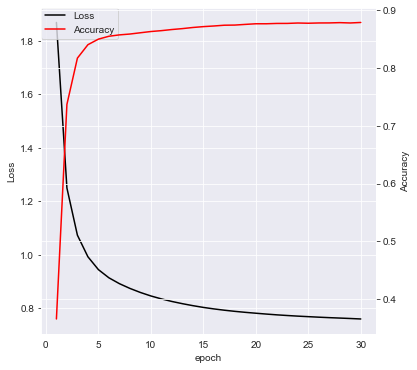

In [4]:
history = pd.read_csv(path + '/history.csv')

fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.plot(range(1, history.index.stop + 1), history['loss'], color='black', label='Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('epoch')
ax2.plot(range(1, history.index.stop + 1), history['accuracy'], color='red', label='Accuracy')
ax2.set_ylabel('Accuracy')
# label1と2には、凡例用に各labelのリスト情報が入る
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
# 凡例をまとめて出力する
ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)

In [8]:
# 混同行列
pred_label = tf.argmax(model.predict(x_test), axis=-1).numpy()
cm = tf.math.confusion_matrix(y_test, pred_label)
label_tot = np.sum(cm, axis=1).reshape(-1, 1)
norm_cm = cm/label_tot

2022-06-04 14:21:06.480791: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-04 14:21:06.550446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Text(0.5, 1.0, 'Normalized confusion matrix')

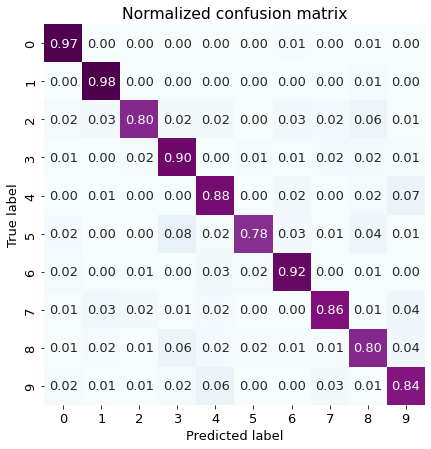

In [12]:
plt.figure(figsize=(7, 7))
sns.heatmap(norm_cm, square=True, cbar=False, annot=True, fmt=".2f", cmap='BuPu')
plt.rcParams["font.size"] = 13
plt.xlabel("Predicted label", fontsize=13)
plt.ylabel("True label", fontsize=13)
plt.title("Normalized confusion matrix")

2022-06-05 20:17:04.153209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


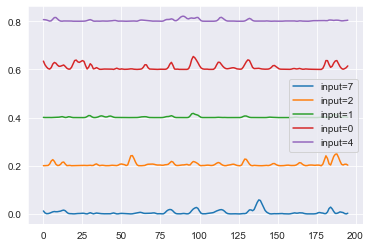

In [6]:
image_num = 5
hidden_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
hidden_pred = hidden_model.predict(x_test[0:image_num,:,:])

for i in range(image_num):
    plt.plot(hidden_pred[i,:] + 0.2*i, label="input="+str(y_test[i]))

plt.legend()

In [12]:
y_onehot = tf.one_hot(y_test, 10)

y_pred = model.predict(x_test)
loss = tf.losses.categorical_crossentropy(y_onehot, y_pred)

In [18]:
y_pred = model.predict(x_train)
y_test_pattern = categorical_output(y_train, width=14*14, padding=0.2)
loss = tf.losses.mean_squared_error(y_test_pattern, y_pred)

2022-06-08 17:09:59.464580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [19]:
argmin = np.argmin(loss.numpy())
argmin

9105

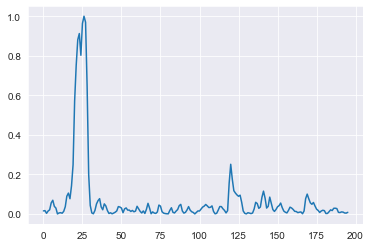

In [30]:
pred = model.predict(np.array([x_test[9105,:,:]]))
plt.plot(pred[0,:])

In [89]:
model.layers[5].get_weights()

[1.55e-06, 4053668.0, 4e-05, 5e-07, 1.0]

In [13]:
pattern = r'modulation'
mo_layers = []
save = False
each_save = True
for layer in model.layers:
    result = re.match(pattern, layer.name)
    if result:
        mo_layers.append(layer)

In [31]:
phase = []
for layer in mo_layers:
    phase.append(layer.get_weights()[0] % (2*np.pi))
phase = np.array(phase).T

hidden_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[2].output)
hidden_pred = hidden_model.predict(np.array([x_train[1,:,:]]))

data = np.hstack([hidden_pred[0,:].reshape([-1, 1]), phase])
data = pd.DataFrame(data, columns=["Intensity", "layer1", "layer2", "layer3", "layer4", "layer5"])
data.to_csv("out/phase.csv")

2022-06-08 17:15:21.539463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
